## Import Packages

In [4]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Utility functions for camera calibration

In [34]:
def find_chessboard_corners(img, rows, cols):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None)
    
    if ret == True:
        return objp, corners
    else:
        return None

def calibrate_camera(filenames, rows, cols):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    img_size = None

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(filenames):
        img = cv2.imread(fname)
        
        # Assume calibration and test images have the same dimensions!
        if img_size is None:
            img_size = (img.shape[1], img.shape[0])

        res = find_chessboard_corners(img, rows, cols)
        if res is not None:   
            objp, corners = res
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print(fname)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

## Extract object points and image points for camera calibration

['camera_cal/calibration2.jpg']


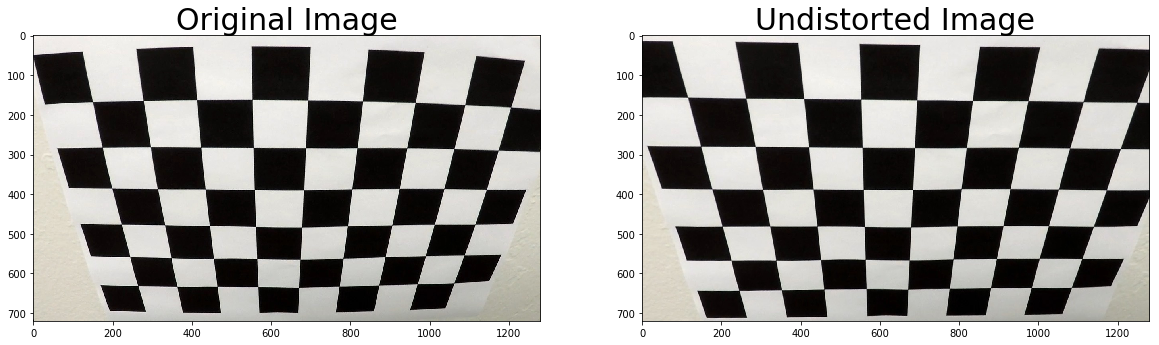

In [35]:
# Define chessboard size
rows = 6
cols = 9

# Make a list of calibration images
#images = glob.glob('camera_cal/calibration*.jpg')
images = ['camera_cal/calibration2.jpg']

print(images)

# Get calibration params
mtx, dist = calibrate_camera(images, rows, cols)

# Test undistortion on an image
#img = cv2.imread('test_images/test1.jpg')
img = cv2.imread('camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

## Utility functions for filtering an image

In [27]:
def s_select(img, thresh=(150, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def sobel_select(img, thresh=(20,100)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def combine_binary(a, b):
    combined = np.zeros_like(a)
    combined[(a == 1) | (b == 1)] = 1
    return combined

## Test combined S channel and Sobel filter

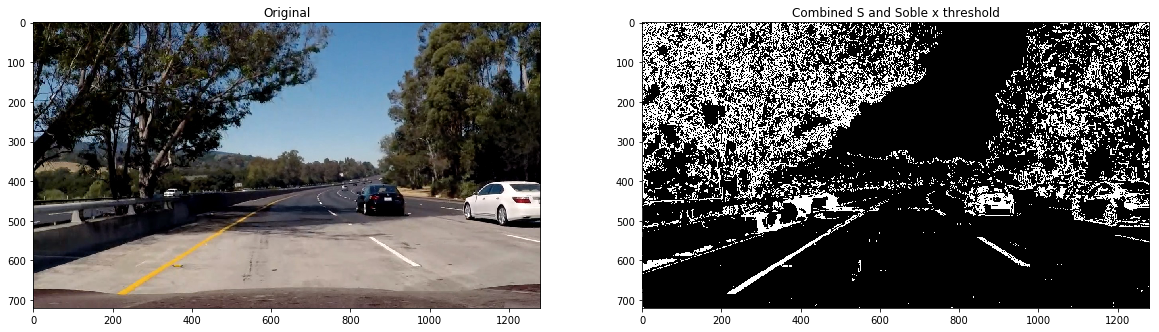

In [33]:
image = cv2.imread('test_images/test5.jpg') 

s_binary = s_select(image)
sobelx_binary = sobel_select(image)
combined_binary = combine_binary(s_binary, sobelx_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

ax2.set_title('Combined S and Soble x threshold')
ax2.imshow(combined_binary, cmap='gray')

## Utility functions for perspective transform

In [131]:
def src_dst(img):    
    rows = img.shape[0] - 1
    cols = img.shape[1] - 1
    midx = cols // 2
    midy = rows // 2
    # Define 4 source points
    top = 46
    bottom = 470
    height = 270
    boffset = 20
    toffset = 0
    src = [[midx-bottom+boffset,rows],[midx-top+toffset,rows-height],[midx+top+toffset,rows-height],[midx+bottom+boffset,rows]]
    # Define 4 destination points
    width = 350
    dst = [[midx-width,rows],[midx-width,0],[midx+width,0],[midx+width,rows]]
    return src, dst
    
def lane_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(np.array(src, np.float32), np.array(dst, np.float32))
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(copy, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


## Test perspective warp

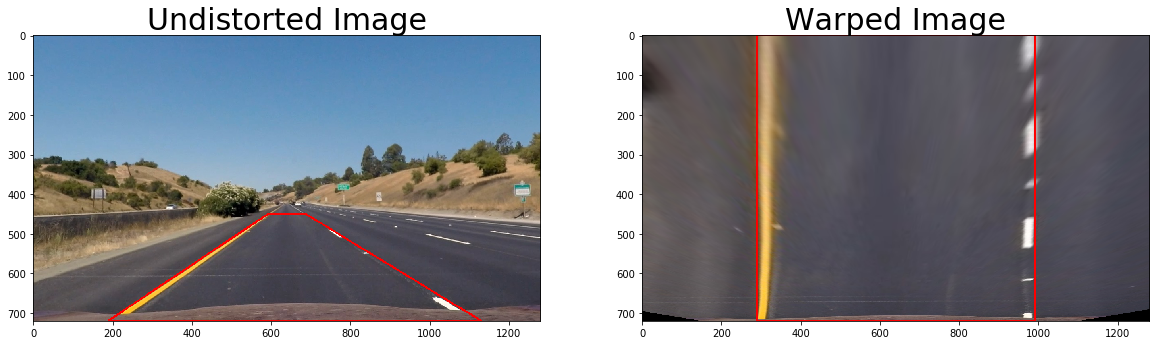

In [133]:
# Read in an image, you can also try test1.jpg or test4.jpg
image = cv2.imread('test_images/straight_lines1.jpg') 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(image, mtx, dist, None, mtx)
src, dst = src_dst(undist)
warped = lane_transform(undist, src, dst)

undist_copy = undist.copy()
warped_copy = warped.copy()
cv2.polylines(undist_copy,[np.array(src, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)
cv2.polylines(warped_copy,[np.array(dst, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_copy)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped_copy)
ax2.set_title('Warped Image', fontsize=30)